# Project 8

## SET UP ENV

In [1]:
# use boto for EC2 > S3 authentication

import os
import boto3

session = boto3.Session(profile_name='default')
credentials = session.get_credentials()

AWS_ACCESS_KEY_ID     = credentials.access_key
AWS_SECRET_ACCESS_KEY = credentials.secret_key

os.environ['AWS_ACCESS_KEY_ID'] = AWS_ACCESS_KEY_ID
os.environ['AWS_SECRET_ACCESS_KEY'] = AWS_SECRET_ACCESS_KEY

In [2]:
# Environment initialisation

import findspark
import os

os.environ["PYSPARK_DRIVER_PYTHON"] = "jupyter"
os.environ["PYSPARK_PYTHON"] = "python3"
findspark.init()

# Spark session
from pyspark.sql import SparkSession
spark = SparkSession\
    .builder\
    .appName("ocp8_asp_fruits")\
    .getOrCreate()

sc = spark.sparkContext

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


22/12/09 13:11:10 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
# show spark is initalised

sc

<SparkContext master=local[*] appName=ocp8_asp_fruits>

In [4]:
sc.uiWebUrl

'http://ip-172-31-46-144.eu-west-3.compute.internal:4040'

In [5]:
# import needed pyspark objects

from pyspark.sql.functions import udf, pandas_udf
from pyspark.ml.image import ImageSchema
from pyspark.ml.linalg import DenseVector, VectorUDT
from pyspark.sql.types import ArrayType, IntegerType, StringType, FloatType, BinaryType, StructType, StructField

from pyspark.sql.functions import col, pandas_udf, PandasUDFType

# from PIL import Image, ImageDraw

ImageSchema.imageFields

['origin', 'height', 'width', 'nChannels', 'mode', 'data']

## READ FILES

In [43]:
# constants for reading images from S3

BUCKET = "oc-p8-s3-adamphillips"
PATTERN = "images/"
OUT_PARQUET = f"s3a://{BUCKET}/result/features.parquet"

In [7]:
#read images

src = spark.read.format("image").option("recursiveFileLookup", "true").load(f"s3a://{BUCKET}/{PATTERN}").repartition(15).cache()
src.show()

22/12/09 13:11:14 WARN MetricsConfig: Cannot locate configuration: tried hadoop-metrics2-s3a-file-system.properties,hadoop-metrics2.properties


+--------------------+
|               image|
+--------------------+
|{s3a://oc-p8-s3-a...|
|{s3a://oc-p8-s3-a...|
|{s3a://oc-p8-s3-a...|
|{s3a://oc-p8-s3-a...|
|{s3a://oc-p8-s3-a...|
|{s3a://oc-p8-s3-a...|
|{s3a://oc-p8-s3-a...|
|{s3a://oc-p8-s3-a...|
|{s3a://oc-p8-s3-a...|
|{s3a://oc-p8-s3-a...|
|{s3a://oc-p8-s3-a...|
|{s3a://oc-p8-s3-a...|
|{s3a://oc-p8-s3-a...|
|{s3a://oc-p8-s3-a...|
|{s3a://oc-p8-s3-a...|
|{s3a://oc-p8-s3-a...|
|{s3a://oc-p8-s3-a...|
|{s3a://oc-p8-s3-a...|
|{s3a://oc-p8-s3-a...|
|{s3a://oc-p8-s3-a...|
+--------------------+
only showing top 20 rows



In [8]:
# show the spark image schema

src.printSchema()

root
 |-- image: struct (nullable = true)
 |    |-- origin: string (nullable = true)
 |    |-- height: integer (nullable = true)
 |    |-- width: integer (nullable = true)
 |    |-- nChannels: integer (nullable = true)
 |    |-- mode: integer (nullable = true)
 |    |-- data: binary (nullable = true)



## IMAGES TO DATAFRAME

In [9]:
# define UDFs

@udf(VectorUDT())
def image2vec(image):
    return DenseVector(ImageSchema.toNDArray(image).flatten())

@udf(VectorUDT())
def image2shape(image):
    return DenseVector(ImageSchema.toNDArray(image).shape)

@udf(VectorUDT())
def shape(array):
    return DenseVector(array.shape)

@udf(StringType())
def typecol(array):
    return type(array)

@udf(StringType())
def origin2category(origin):
    return origin.split('/')[-2]

In [10]:
# create category from image origin (file path)

src = src \
    .withColumn('category', origin2category("image.origin")) \
    .cache()

In [11]:
# src shape

print((src.count(), len(src.columns)))

(31, 2)


In [12]:
# show

src.show(5)

+--------------------+--------+
|               image|category|
+--------------------+--------+
|{s3a://oc-p8-s3-a...|  ginger|
|{s3a://oc-p8-s3-a...|    pear|
|{s3a://oc-p8-s3-a...|  ginger|
|{s3a://oc-p8-s3-a...|  banana|
|{s3a://oc-p8-s3-a...|    pear|
+--------------------+--------+
only showing top 5 rows



## IMAGE VECTORISATION WITH SPARK

In [13]:
# imports needed for tensorflow vgg16 image vectorisation

import numpy as np
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input as ppi_vgg16
# from tensorflow.keras.models import Sequential
# import tensorflow as tf
# ppi = tensorflow.keras.applications.vgg16.preprocess_input


2022-12-09 13:11:26.608744: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-09 13:11:26.901238: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-12-09 13:11:26.901272: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-12-09 13:11:28.063616: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2022-

In [14]:
# define model used in vgg16 vectorisation

model = VGG16(include_top=False, pooling='max', weights='imagenet')

2022-12-09 13:11:29.627312: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-12-09 13:11:29.627360: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2022-12-09 13:11:29.627385: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (ip-172-31-46-144): /proc/driver/nvidia/version does not exist
2022-12-09 13:11:29.627624: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [15]:
# UDF to parallelise the vectorisation

# TODO find equivalent to tf.cast to scale features before vectorisation

@udf(VectorUDT())
def image2features(image):
    array = ImageSchema.toNDArray(image)
    # ...find equivalent to tf.cast
    img = ppi_vgg16(np.expand_dims(array.copy(), axis=0))
    features = model.predict(img)
    return DenseVector(features.flatten())

In [16]:
# vecctorise the images
# executed in the driver that will map the UDF to each worker by partitions

src = src.withColumn("features", image2features("image")).cache()

Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers
......conv2d
.........vars
............0
............1
......conv2d_1
.........vars
............0
............1
......conv2d_10
.........vars
............0
............1
......conv2d_11
.........vars
............0
............1
......conv2d_12
.........vars
............0
............1
......conv2d_2
.........vars
............0
............1
......conv2d_3
.........vars
............0
............1
......conv2d_4
.........vars
............0
............1
......conv2d_5
.........vars
............0
............1
......conv2d_6
.........vars
............0
............1
......conv2d_7
.........vars
............0
............1
......conv2d_8
.........vars
............0
............1
......conv2d_9
.........vars
............0
............1
......global_max_pooling2d
.........vars
......input_layer
.........vars
......max_pooling2d
.........vars
......max_pooling2d_1
.........vars
......max_pooling2d_2
.........vars
...

In [17]:
src.show()

2022-12-09 13:11:31.925547: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-09 13:11:32.081595: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-12-09 13:11:32.081934: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-12-09 13:11:32.923689: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2022-

1/1 [==============================] - 0s 122ms/step
Keras model archive loading:===========>                            (2 + 2) / 4]
File Name                                             Modified             Size
config.json                                    2022-12-09 13:11:30        10342
metadata.json                                  2022-12-09 13:11:30           64
variables.h5                                   2022-12-09 13:11:30     58910344
Keras model archive loading:
File Name                                             Modified             Size
config.json                                    2022-12-09 13:11:30        10342
metadata.json                                  2022-12-09 13:11:30           64
variables.h5                                   2022-12-09 13:11:30     58910344
2022-12-09 13:11:39.167439: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared obj

Keras weights file (<HDF5 file "variables.h5" (mode r)>) loading:
...layers
......conv2d
.........vars
............0
............1
......conv2d_1
.........vars
............0
............1
......conv2d_10
.........vars
............0
............1
......conv2d_11
.........vars
............0
............1
......conv2d_12
.........vars
............0
............1
......conv2d_2
.........vars
............0
............1
......conv2d_3
.........vars
............0
............1
......conv2d_4
.........vars
............0
............1
......conv2d_5
.........vars
............0
............1
......conv2d_6
.........vars
............0
............1
......conv2d_7
.........vars
............0
............1
......conv2d_8
.........vars
............0
............1
......conv2d_9
.........vars
............0
............1
......global_max_pooling2d
.........vars
......input_layer
.........vars
......max_pooling2d
.........vars
......max_pooling2d_1
.........vars
......max_pooling2d_2
.........vars
...

1/1 [==============================] - 0s 141ms/step
Keras model archive loading:=================================>      (8 + 1) / 9]
File Name                                             Modified             Size
config.json                                    2022-12-09 13:11:30        10342
metadata.json                                  2022-12-09 13:11:30           64
variables.h5                                   2022-12-09 13:11:30     58910344
Keras weights file (<HDF5 file "variables.h5" (mode r)>) loading:
...layers
......conv2d
.........vars
............0
............1
......conv2d_1
.........vars
............0
............1
......conv2d_10
.........vars
............0
............1
......conv2d_11
.........vars
............0
............1
......conv2d_12
.........vars
............0
............1
......conv2d_2
.........vars
............0
............1
......conv2d_3
.........vars
............0
............1
......conv2d_4
.........vars
............0
............1
......conv2d_

+--------------------+-----------+--------------------+
|               image|   category|            features|
+--------------------+-----------+--------------------+
|{s3a://oc-p8-s3-a...|     ginger|[48.4337806701660...|
|{s3a://oc-p8-s3-a...|       pear|[0.0,0.0,0.0,0.0,...|
|{s3a://oc-p8-s3-a...|     ginger|[95.2796325683593...|
|{s3a://oc-p8-s3-a...|     banana|[0.0,0.0,0.0,0.0,...|
|{s3a://oc-p8-s3-a...|       pear|[0.0,0.0,0.0,0.0,...|
|{s3a://oc-p8-s3-a...|       pear|[0.0,0.0,0.0,0.0,...|
|{s3a://oc-p8-s3-a...|     ginger|[88.5185012817382...|
|{s3a://oc-p8-s3-a...|     banana|[0.0,0.0,0.0,3.31...|
|{s3a://oc-p8-s3-a...|cauliflower|[190.048385620117...|
|{s3a://oc-p8-s3-a...|       pear|[0.0,0.0,0.0,0.0,...|
|{s3a://oc-p8-s3-a...|cauliflower|[226.782043457031...|
|{s3a://oc-p8-s3-a...|     banana|[0.0,0.0,6.200960...|
|{s3a://oc-p8-s3-a...|     ginger|[13.6362237930297...|
|{s3a://oc-p8-s3-a...|     banana|[0.0,0.0,35.92523...|
|{s3a://oc-p8-s3-a...|cauliflower|[187.831390380

## PRE-PCA SCALING

In [18]:
from pyspark.ml.feature import StandardScaler, PCA

In [19]:
# scaling the vector for PCA

standardScaler = StandardScaler()
standardScaler.setInputCol("features")
standardScaler.setOutputCol("scaled_features")
model = standardScaler.fit(src)
src = model.transform(src)
src.show()

Keras model archive loading:
File Name                                             Modified             Size
config.json                                    2022-12-09 13:11:30        10342
metadata.json                                  2022-12-09 13:11:30           64
variables.h5                                   2022-12-09 13:11:30     58910344
Keras weights file (<HDF5 file "variables.h5" (mode r)>) loading: (14 + 1) / 15]
...layers
......conv2d
.........vars
............0
............1
......conv2d_1
.........vars
............0
............1
......conv2d_10
.........vars
............0
............1
......conv2d_11
.........vars
............0
............1
......conv2d_12
.........vars
............0
............1
......conv2d_2
.........vars
............0
............1
......conv2d_3
.........vars
............0
............1
......conv2d_4
.........vars
............0
............1
......conv2d_5
.........vars
............0
............1
......conv2d_6
.........vars
............0
...

+--------------------+-----------+--------------------+--------------------+
|               image|   category|            features|     scaled_features|
+--------------------+-----------+--------------------+--------------------+
|{s3a://oc-p8-s3-a...|     ginger|[48.4337806701660...|[0.72099862768035...|
|{s3a://oc-p8-s3-a...|       pear|[0.0,0.0,0.0,0.0,...|[0.0,0.0,0.0,0.0,...|
|{s3a://oc-p8-s3-a...|     ginger|[95.2796325683593...|[1.41835890936325...|
|{s3a://oc-p8-s3-a...|     banana|[0.0,0.0,0.0,0.0,...|[0.0,0.0,0.0,0.0,...|
|{s3a://oc-p8-s3-a...|       pear|[0.0,0.0,0.0,0.0,...|[0.0,0.0,0.0,0.0,...|
|{s3a://oc-p8-s3-a...|       pear|[0.0,0.0,0.0,0.0,...|[0.0,0.0,0.0,0.0,...|
|{s3a://oc-p8-s3-a...|     ginger|[88.5185012817382...|[1.31771084283263...|
|{s3a://oc-p8-s3-a...|     banana|[0.0,0.0,0.0,3.31...|[0.0,0.0,0.0,1.98...|
|{s3a://oc-p8-s3-a...|cauliflower|[190.048385620117...|[2.82911272523013...|
|{s3a://oc-p8-s3-a...|       pear|[0.0,0.0,0.0,0.0,...|[0.0,0.0,0.0,0.0,...|

## PCA with 2 COMPONENTS

In [31]:
# run PCA decomposition with 2 components

n_pca_composants = 5

# src = src.drop('pca_features')

pca = PCA(k=n_pca_composants, inputCol="scaled_features")
pca.setOutputCol("pca_features")
model = pca.fit(src)
src = model.transform(src)
src.show(5)

+--------------------+--------+--------------------+--------------------+--------------------+
|               image|category|            features|     scaled_features|        pca_features|
+--------------------+--------+--------------------+--------------------+--------------------+
|{s3a://oc-p8-s3-a...|  ginger|[48.4337806701660...|[0.72099862768035...|[-11.514528838734...|
|{s3a://oc-p8-s3-a...|    pear|[0.0,0.0,0.0,0.0,...|[0.0,0.0,0.0,0.0,...|[4.39253051305722...|
|{s3a://oc-p8-s3-a...|  ginger|[95.2796325683593...|[1.41835890936325...|[-8.5884844957947...|
|{s3a://oc-p8-s3-a...|  banana|[0.0,0.0,0.0,0.0,...|[0.0,0.0,0.0,0.0,...|[4.76914978513427...|
|{s3a://oc-p8-s3-a...|    pear|[0.0,0.0,0.0,0.0,...|[0.0,0.0,0.0,0.0,...|[2.23535146332155...|
+--------------------+--------+--------------------+--------------------+--------------------+
only showing top 5 rows



In [32]:
# show resulting PCA column 'pca_features', and it's shape

src.withColumn('pca_features_type',shape('pca_features')).show(5)


+--------------------+--------+--------------------+--------------------+--------------------+-----------------+
|               image|category|            features|     scaled_features|        pca_features|pca_features_type|
+--------------------+--------+--------------------+--------------------+--------------------+-----------------+
|{s3a://oc-p8-s3-a...|  ginger|[48.4337806701660...|[0.72099862768035...|[-11.514528838734...|            [5.0]|
|{s3a://oc-p8-s3-a...|    pear|[0.0,0.0,0.0,0.0,...|[0.0,0.0,0.0,0.0,...|[4.39253051305722...|            [5.0]|
|{s3a://oc-p8-s3-a...|  ginger|[95.2796325683593...|[1.41835890936325...|[-8.5884844957947...|            [5.0]|
|{s3a://oc-p8-s3-a...|  banana|[0.0,0.0,0.0,0.0,...|[0.0,0.0,0.0,0.0,...|[4.76914978513427...|            [5.0]|
|{s3a://oc-p8-s3-a...|    pear|[0.0,0.0,0.0,0.0,...|[0.0,0.0,0.0,0.0,...|[2.23535146332155...|            [5.0]|
+--------------------+--------+--------------------+--------------------+--------------------+--

In [39]:
# show explained component contributions

model.explainedVariance

DenseVector([0.1831, 0.1488, 0.0931, 0.0655, 0.054])

In [23]:
# np.array([row.pca_features.toArray() for row in src.collect()])


## SCATTER PLOT OF FIRST TWO PCA COMPONENTS 

In [37]:
# create pandas dataframe of category and pca component arrays (DenseArray)

import pandas as pd

scatter_df = src.select('category','pca_features').toPandas()
print(scatter_df.shape)
print(scatter_df.head())

(31, 2)
  category                                       pca_features
0   ginger  [-11.514528838734154, 5.017705741417342, -3.41...
1     pear  [4.392530513057222, -5.872184142108527, 1.9817...
2   ginger  [-8.588484495794715, 3.170802681799313, -1.250...
3   banana  [4.769149785134274, 16.79556137010678, 7.77508...
4     pear  [2.2353514633215514, -3.90157012135223, 0.7370...


In [38]:
# split pca_features column into seperate columns, drop the pca_features column

# scatter_df[['pca_comp_1','pca_comp_2']] = pd.DataFrame(scatter_df.pca_features.tolist(), index= scatter_df.index)

scatter_df[[f'pca_comp_{i+1}' for i in range(n_pca_composants)]] = pd.DataFrame(scatter_df.pca_features.tolist(), index= scatter_df.index)

scatter_df = scatter_df.drop(columns=['pca_features'])
print(scatter_df.head())


  category  pca_comp_1  pca_comp_2  pca_comp_3  pca_comp_4  pca_comp_5
0   ginger  -11.514529    5.017706   -3.416366    1.598259    7.432665
1     pear    4.392531   -5.872184    1.981725    0.375992   -3.998519
2   ginger   -8.588484    3.170803   -1.250674    2.121820    0.991631
3   banana    4.769150   16.795561    7.775085    6.378813   -3.624395
4     pear    2.235351   -3.901570    0.737080    1.453190   -6.238437


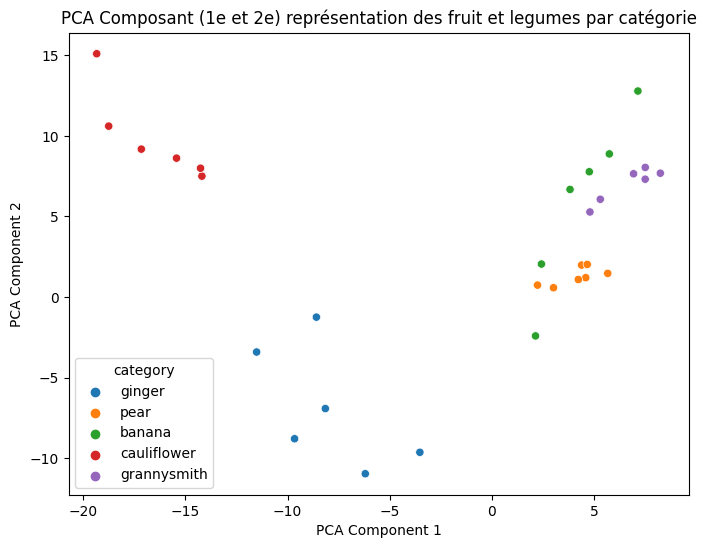

In [42]:
# plot pca components and category scatter with seaborn

import seaborn as sns
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)

sns.scatterplot(data=scatter_df, x='pca_comp_1', y='pca_comp_2', hue='category')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('PCA Composant (1e et 2e) représentation des fruit et legumes par catégorie')
plt.show()

In [45]:
# .repartition(4)

src.select('category','pca_features').repartition(4) \
    .write.mode("overwrite") \
    .parquet(OUT_PARQUET)

spark.read.parquet(OUT_PARQUET).show()

+-----------+--------------------+
|   category|        pca_features|
+-----------+--------------------+
|       pear|[4.66994227912870...|
|     ginger|[-9.6574691666101...|
|cauliflower|[-14.193282966995...|
|cauliflower|[-18.754613503524...|
|     banana|[2.42714045548883...|
|     ginger|[-8.1513539169711...|
|       pear|[5.67096099856423...|
|grannysmith|[6.93497065373824...|
|grannysmith|[7.50715578628914...|
|       pear|[3.01696289634182...|
|     banana|[7.14839961720936...|
|       pear|[4.5937516477988,...|
|grannysmith|[4.79987078565566...|
|grannysmith|[7.50387824185359...|
|cauliflower|[-15.435480038629...|
|       pear|[4.23186525692030...|
|cauliflower|[-17.157828426342...|
|grannysmith|[8.24643044467261...|
|     banana|[2.13720989659540...|
|     ginger|[-11.514528838734...|
+-----------+--------------------+
only showing top 20 rows



In [54]:
# Not sure if still needed
    
# ! aws s3api put-object-acl --acl public-read --bucket oc-p8-s3-adamphillips --key result/features.parquet/_SUCCESS

In [55]:
sc.stop()